## <font color='green'> <div align="center">In the name of God </div></font>

### <font color='red'> Author: Sayed Kamaledin Ghiasi-Shrirazi <a href="http://profsite.um.ac.ir/~k.ghiasi">(http://profsite.um.ac.ir/~k.ghiasi)</a> </font>

# Comparing running time of traditional <font color='red'>eigen</font> and the novel <font color='red'>lstsq</font> solvers for Fisher LDA

##### Importing general modules.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import sklearn
import scipy.stats as st
import time
import matplotlib as mpl

##### Importing modules wtitten by the author

In [2]:
from LinearDiscriminantAnalysis import LinearDiscriminantAnalysis
from LDATrainingDataPreparation import TrainingData

##### Defining a function for generating N samples of dimension dim

The data comes from a 2-class classification problem, where each class consists of 3 clusters.
Samples are drawn from Gaussian distributions with a specific covariance matrix.
Here, I have generated samples without **np.random.multivariate_normal** to speedup dataset generation.

In [3]:
def prepareDataset (N, dim):
    nClasses = 3
    nClusters = 1
    theta = np.pi / 4
    p3 = 1 / 3
    p2 = 1 / 3
    p1 = 1 / 3
    Ki = np.array([1, 1, 1], dtype=int)
    NKi = np.array([[p1 * N], [p2 * N], [p3 * N]], dtype=int)
    position = np.array([[[0, -1]], [[0, 0]], [[0, 1]]])

    R = np.array([[np.cos(theta), np.sin(theta)], [-np.sin(theta), np.cos(theta)]])
    means = np.zeros([nClasses, nClusters, dim])
    for i in range(nClasses):
        for j in range(nClusters):
            x, y = position[i, j]
            m = R @ np.sqrt(np.diag([1, 4])) @ np.array([x, y]) * 5 / np.sqrt(2)
            means[i, j, 0] = m[0]
            means[i, j, 1] = m[1]
            means[i, j, 2:] = 0

    scales = [0.25, 9]
    S = np.diag(scales)
    cov2 = R @ S @ R.T
    cov = np.zeros([dim, dim])
    cov[0:2, 0:2] = cov2
    for i in range(2, dim):
        cov[i, i] = scales[0]

    N = np.sum (NKi)
    XTrain = np.zeros ([N, dim])
    yTrain = np.zeros (N)
    idx = 0
    for i in range (nClasses):
        for j in range(nClusters):
            Xi_first = np.random.multivariate_normal (np.zeros(2), cov2, NKi[i, j])
            Xi_rest = np.random.randn(NKi[i, j], dim-2)
            Xi_rest *= scales[0]
            Xi = np.hstack([Xi_first,Xi_rest])
            Xi += means[i,j,:]            
            #Xi = np.random.multivariate_normal (means[i,j,:], cov, NKi[i, j])
            XTrain[idx:idx + NKi[i, j], :] = Xi
            yTrain[idx:idx + NKi[i, j]] = i
            idx += NKi[i, j]

    yTrain = np.array(yTrain, dtype='int')

    td = TrainingData(XTrain, yTrain)
    td.setSubclasses(Ki, NKi)
    return td, means

##### Defining a function for measuring running time of a solver on a dataset.

In [4]:
def performExperiment(td, solver):
    lda = LinearDiscriminantAnalysis(td, solver, 'Sb', 'St', 0.00, 0.0001)

    start = time.time()
    lda.fitFeatureExtractor()
    end = time.time()
    
    # Since scatter matrices are now computed,
    # This second call computes the pure time for solving LDA
    lda.fitFeatureExtractor()
    end2 = time.time()
    obj = lda.objective()
    return end - start, end2 - end, obj

##### Performing experiments on N=36000 samples with different dimensions

In [5]:
N = 36000
runtimeTable = np.zeros([2,14-8])
objTable = np.zeros([2,14-8])
for logDim in range(8,14):
    dim = 2 ** logDim
    (td, _) = prepareDataset (N, dim)
    
    solver = 'eigen'
    runTime, runTimePure, obj = performExperiment (td, solver)
    print ('For solver {:>15}, N = {}, dim = {} runtime is {:.4f}, '
           'pure runtime is {:.4f}, objective = {:.4f}'.format(solver, N, dim, runTime, runTimePure, obj))
    runtimeTable[0,logDim-8] = runTime
    objTable[0,logDim-8] = obj
        
    solver = 'ghiasi_lstsq'
    runTime, runTimePure, obj = performExperiment (td, solver)
    print ('For solver {:>15}, N = {}, dim = {} runtime is {:.4f}, '
           'pure runtime is {:.4f}, objective = {:.4f}'.format(solver, N, dim, runTime, runTimePure, obj))
    runtimeTable[1,logDim-8] = runTime
    objTable[1,logDim-8] = obj
    
    #solver = 'ghiasi_pinv'
    #runTime, runTimePure, obj = performExperiment (td, solver)
    #print ('Runnig time for solver {:>15}, N = {}, dim = {} is {} with objective = {}'.format(solver, N, dim, runTime, obj))
    #table[4,logDim-8] = runTime    
    
    #solver = 'svd'
    #runTime, obj = performExperiment (td, solver)
    #print ('Runnig time for solver {:>15}, N = {}, dim = {} is {} with objective = {}'.format(solver, N, dim, runTime, obj))
    #table[2,logDim-8] = runTime
        
    #solver = 'ghiasi_svd'
    #runTime, obj = performExperiment (td, solver)
    #print ('Runnig time for solver {:>15}, N = {}, dim = {} is {} with objective = {}'.format(solver, N, dim, runTime, obj))
    #table[3,logDim-8] = runTime
    

    print ('----------------------------------------------')

For solver           eigen, N = 36000, dim = 256 runtime is 0.2343, pure runtime is 0.0312, objective = 0.7971
For solver    ghiasi_lstsq, N = 36000, dim = 256 runtime is 0.2343, pure runtime is 0.0156, objective = 0.7971
----------------------------------------------
For solver           eigen, N = 36000, dim = 512 runtime is 0.6867, pure runtime is 0.0937, objective = 0.8065
For solver    ghiasi_lstsq, N = 36000, dim = 512 runtime is 0.6873, pure runtime is 0.0625, objective = 0.8065
----------------------------------------------
For solver           eigen, N = 36000, dim = 1024 runtime is 2.3276, pure runtime is 0.4999, objective = 0.8211
For solver    ghiasi_lstsq, N = 36000, dim = 1024 runtime is 2.5307, pure runtime is 0.4843, objective = 0.8211
----------------------------------------------
For solver           eigen, N = 36000, dim = 2048 runtime is 9.6336, pure runtime is 2.5775, objective = 0.8577
For solver    ghiasi_lstsq, N = 36000, dim = 2048 runtime is 9.7633, pure runti

In [8]:
for logDim in range(8,14):
    d = 2 ** logDim
    i = logDim - 8
    print (d, '&',  '%0.4f'%runtimeTable[0,i], '&', '%0.4f'%objTable[0,i], 
              '&', '%0.4f'%runtimeTable[1,i], '&', '%0.4f'%objTable[0,i], '\\\\')

256 & 0.2343 & 0.7971 & 0.2343 & 0.7971 \\
512 & 0.6867 & 0.8065 & 0.6873 & 0.8065 \\
1024 & 2.3276 & 0.8211 & 2.5307 & 0.8211 \\
2048 & 9.6336 & 0.8577 & 9.7633 & 0.8577 \\
4096 & 36.5947 & 0.9275 & 46.8190 & 0.9275 \\
8192 & 184.2973 & 1.0637 & 259.9572 & 1.0637 \\


##### Depicting the distribution of data

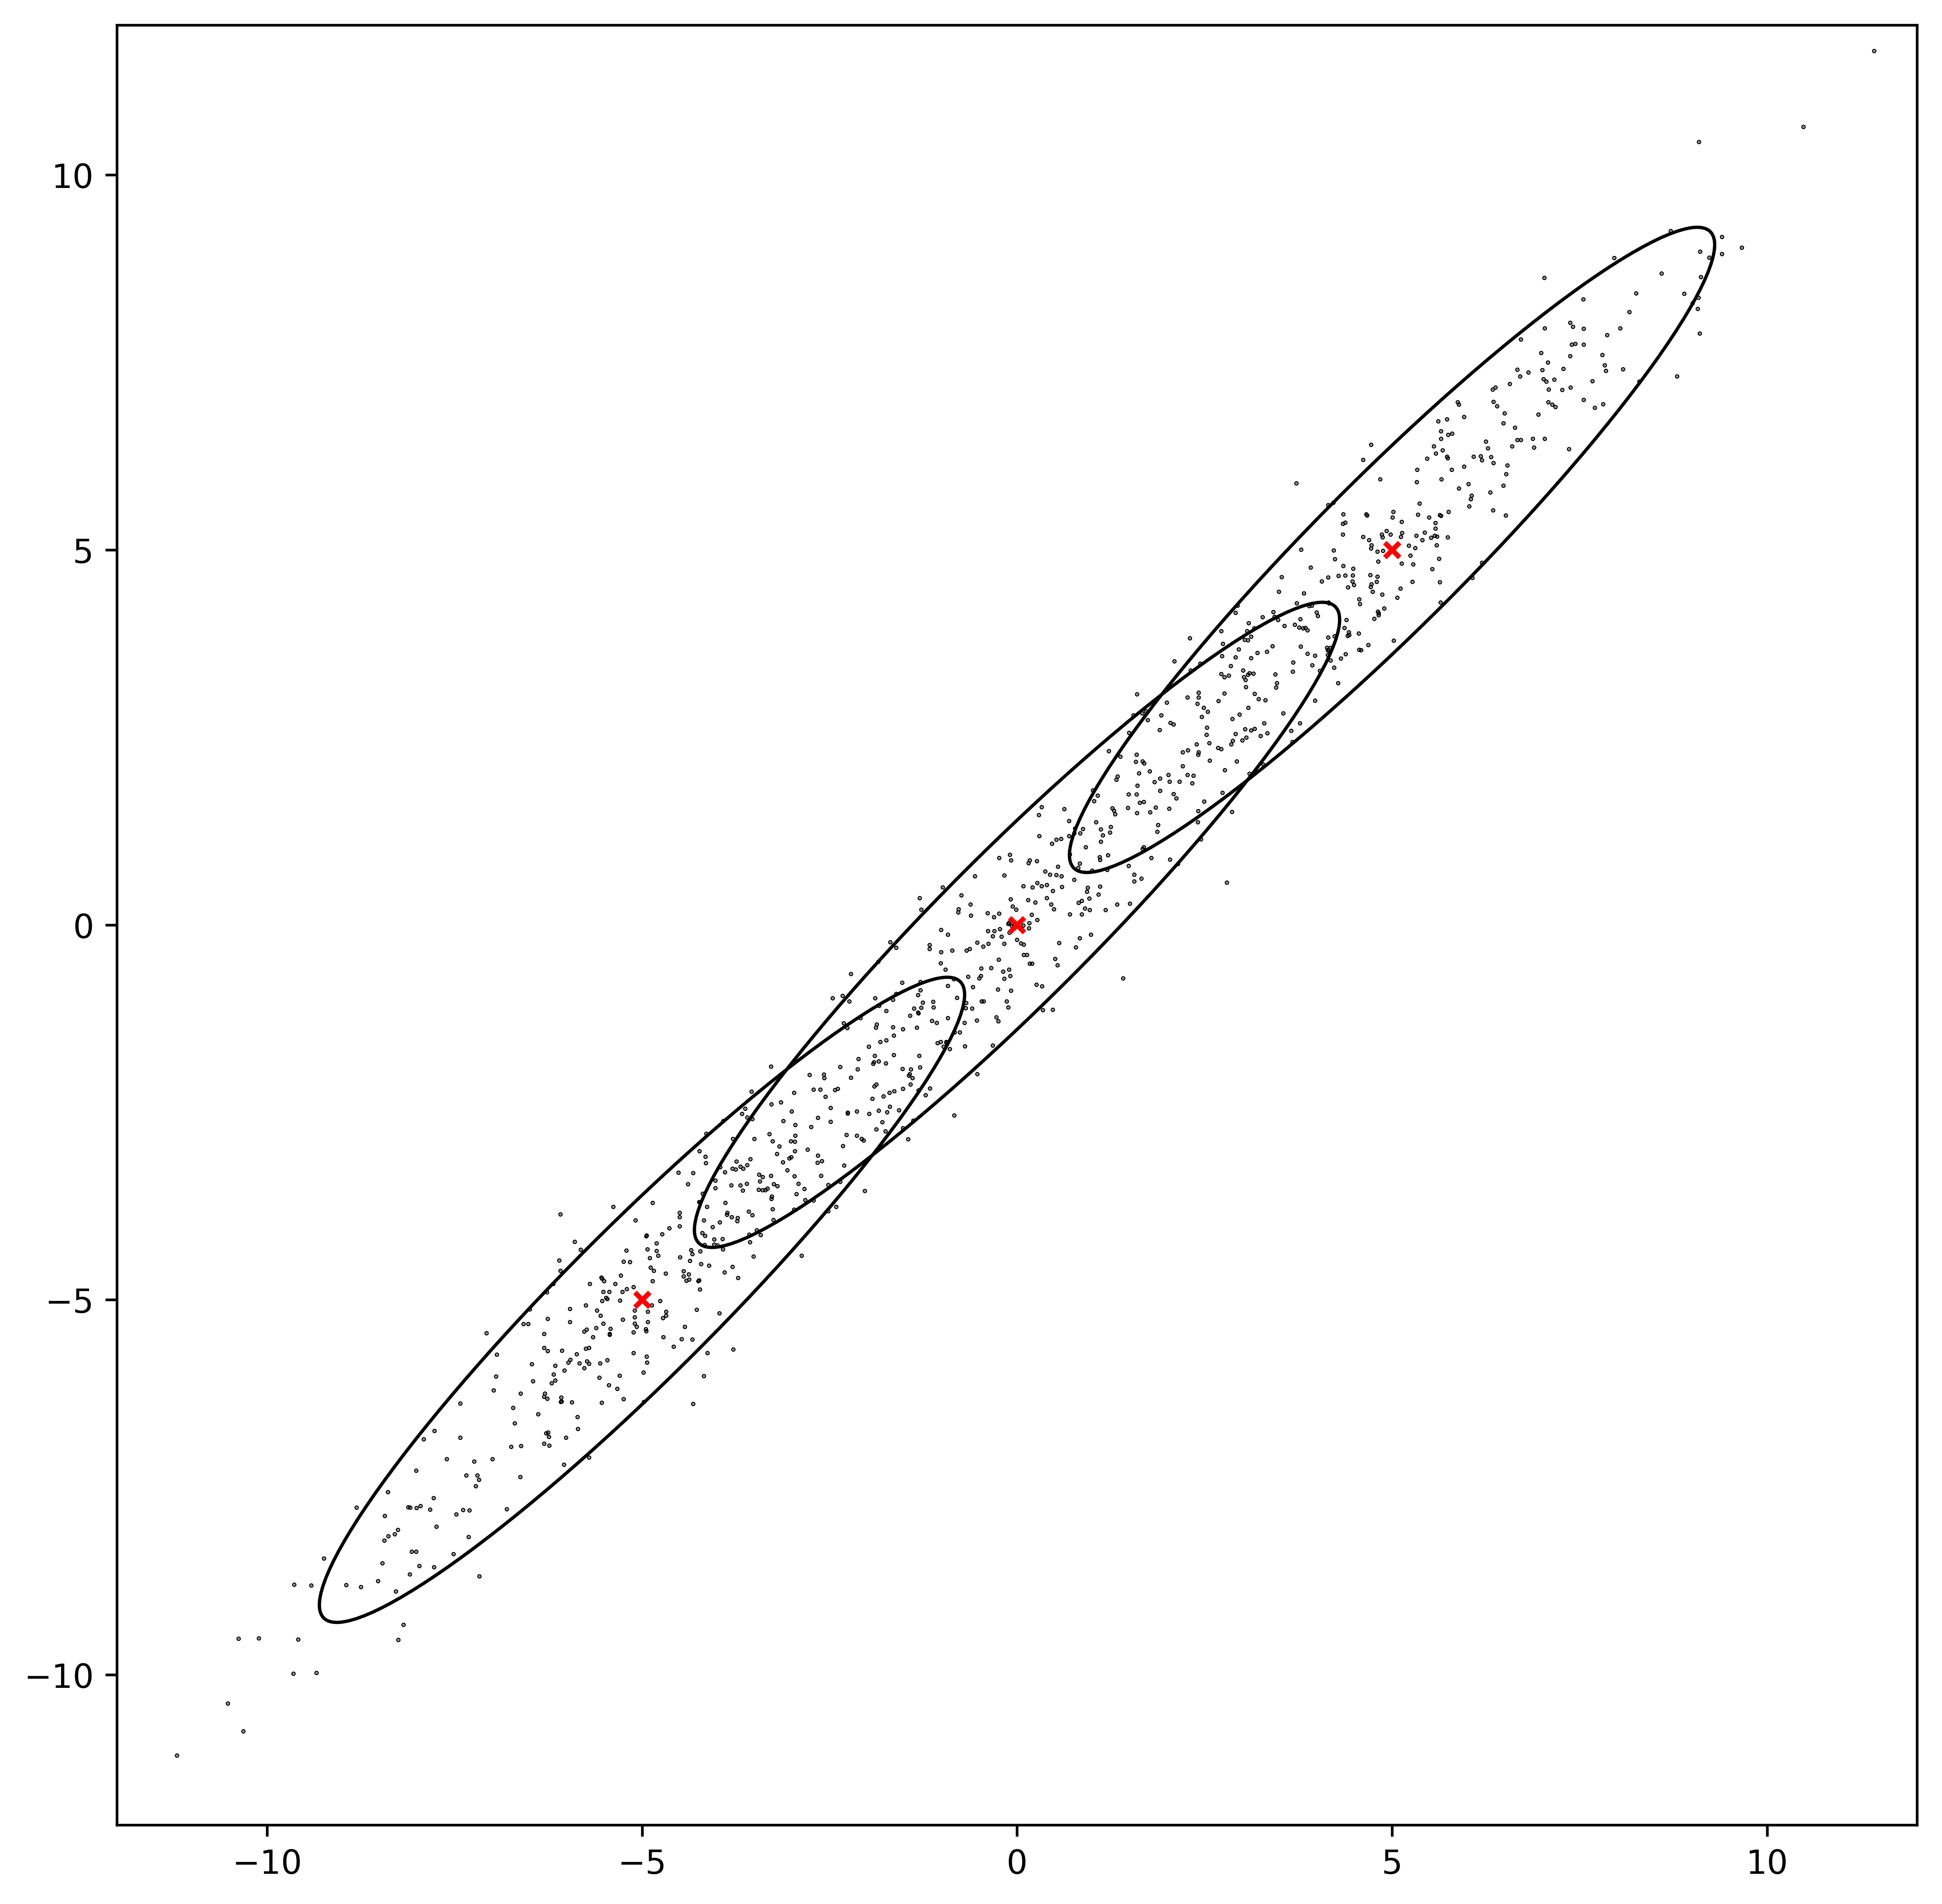

In [7]:
td, means = prepareDataset (1000, 128)
nClasses = 3
nClusters = 1
scales = [0.25, 9]
%matplotlib inline
mpl.rcParams['figure.dpi']= 600
plt.figure(figsize=[10,10])
ax = plt.subplot(111, aspect='equal')
color_map = np.array(['blue', 'green', 'black'])
plt.scatter(td.X[:, 0], td.X[:, 1], s=0.1, c='black')
means_computed = means[:,:,0:2].reshape([-1,2])
plt.scatter(means_computed[:,0], means_computed[:,1], s=20, marker='x', c='red')
s = 4
for i in range (nClasses):
    for j in range(nClusters):
        width = np.sqrt(scales[0]) * s
        height = np.sqrt(scales[1]) * s
        e = Ellipse(means[i,j,0:2], width, height, -45, facecolor = 'none', edgecolor = 'k')
        ax.add_artist(e)
plt.xlim(-12, 12)
plt.ylim(-12, 12)
#plt.axis('off')
plt.show()

### <font color='red'> Author: Sayed Kamaledin Ghiasi-Shrirazi <a href="http://profsite.um.ac.ir/~k.ghiasi">(http://profsite.um.ac.ir/~k.ghiasi)</a> </font>